In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
import numpy as np
import pandas as pd

from transformer_lens import HookedTransformer
from analysis.plots import *
from analysis.activations import make_dataset_df
from explain import *

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [4]:
var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)


In [5]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
alphabet_cols = [f'{c}_unigram' for c in alphabet]
starts_with_cols = [f'starts_w_{c}' for c in alphabet]

In [6]:
alphabet_neurons = pd.concat([var_red_df[alphabet_cols].max(axis=0), var_red_df[alphabet_cols].idxmax(axis=0)], axis=1).rename(columns={0: 'variance_reduction', 1: 'neuron'})
alphabet_neurons['layer'] = alphabet_neurons['neuron'].apply(lambda x: int(x.split('.')[0]))
alphabet_neurons['neuron'] = alphabet_neurons['neuron'].apply(lambda x: int(x.split('.')[1]))
alphabet_neurons.index.name = 'feature'
alphabet_neurons = alphabet_neurons.reset_index()

In [7]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

dataset_df = make_dataset_df(ds, decoded_vocab)
neurons = alphabet_neurons.query('variance_reduction > 0.35')[['layer', 'neuron']].values
activation_df, neuron_cols = make_activation_df(dataset_df, 'cached_activations', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', -1, neurons, use_post=False)

In [8]:
vocab_df = pd.read_csv(f'dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

decoded_norm_vocab, token_ix_2_normed_ix = create_normalized_vocab(
    vocab_df, decoded_vocab)

unigram_df = get_unigram_df(
    dataset_df, decoded_norm_vocab, token_ix_2_normed_ix)

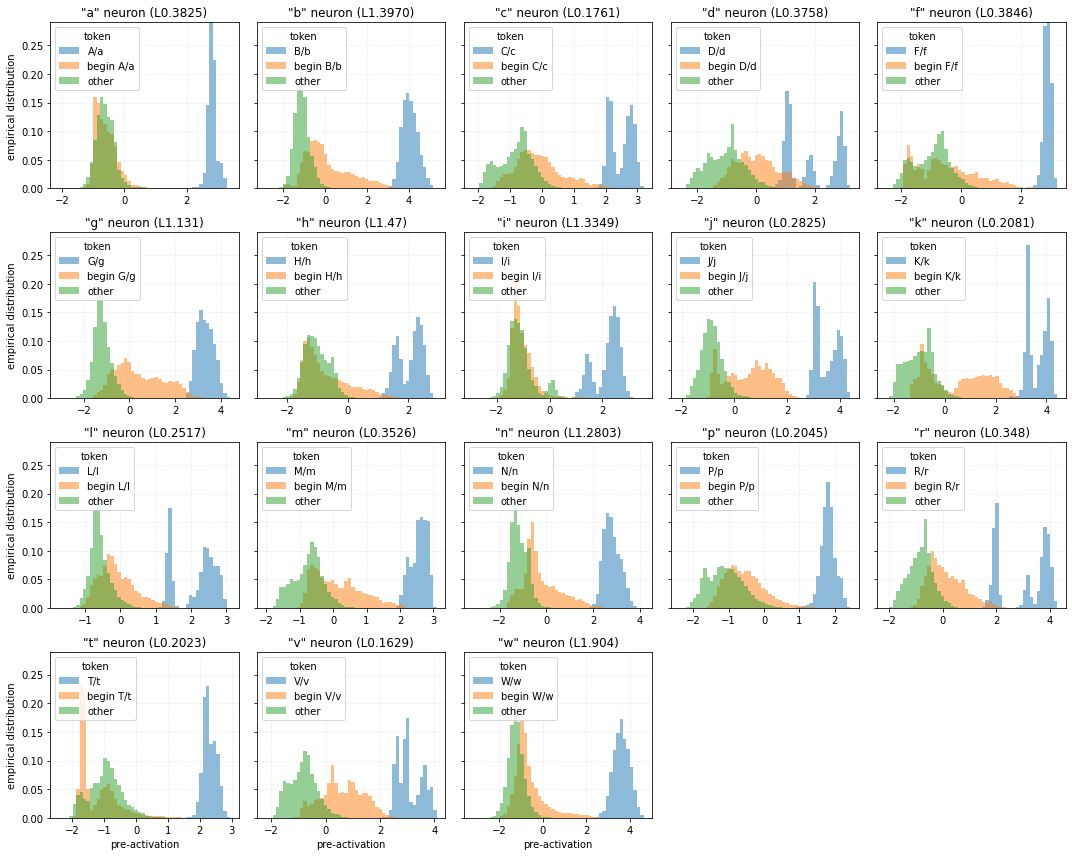

In [53]:
neuron_data = alphabet_neurons.query('variance_reduction > 0.37')[['layer', 'neuron', 'feature']].values
#neuron_data = neuron_data[:8]
n_cols = 5
n_rows = int(np.ceil(len(neuron_data) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharey=True)

ds_tokens = dataset_df.token.values

for ix, (layer, neuron, feature) in enumerate(neuron_data):
    letter = feature[0]
    ax = axs[ix // n_cols, ix % n_cols]
    ax.set_title(f'"{letter}" neuron (L{layer}.{neuron})')
    values = activation_df[f'{layer}.{neuron}']
    classes = np.zeros_like(values)
    letter_tokens = unigram_df[unigram_df[feature]].index.values
    begin_letter_tokens = vocab_df[vocab_df[f'start_w_{letter}']].index.values
    classes[:] = 2
    classes[np.isin(ds_tokens, begin_letter_tokens)] = 1
    classes[np.isin(ds_tokens, letter_tokens)] = 0
    class_labels = [f'{letter.upper()}/{letter}', f'begin {letter.upper()}/{letter}', 'other']
    token_is_letter = activation_df.token.isin(letter_tokens)
    token_histogram_by_class(values, classes, class_labels, ax=ax, legend_loc='upper left')

    ax.set_ylim(top=0.29)
    if ix // n_cols == n_rows - 1:
        ax.set_xlabel('pre-activation')
    else:
        ax.set_xlabel('')
        
    if ix % n_cols == 0:
        ax.set_ylabel('empirical distribution')

    ax.grid(alpha=0.2, linestyle='--')

axs[-1, -1].remove()
axs[-1, -2].remove()

plt.tight_layout()

plt.savefig('figures/alphabet_neurons.png', bbox_inches='tight', dpi=75)



In [55]:
neurons = [(0, 3825), (1, 3970), (0, 1761)]
features = ['a_unigram', 'b_unigram', 'c_unigram']
class_labels = ['X/x token', 'begin X/x', 'other']
#main_activation_df, main_neuron_cols = make_activation_df(dataset_df, 'cached_activations', 'stanford-gpt2-medium-a', 'pile.test.all-10m.512', -1, neurons, use_post=False)

ds_tokens = dataset_df.token.values
neuron_dfs = []
for feature, (layer, neuron) in zip(features, neurons):
    letter = feature[0]
    values = activation_df[f'{layer}.{neuron}']
    classes = np.zeros_like(values, dtype='<U10')
    letter_tokens = unigram_df[unigram_df[feature]].index.values
    begin_letter_tokens = vocab_df[vocab_df[f'start_w_{letter}']].index.values
    classes[:] = class_labels[2]
    classes[np.isin(ds_tokens, begin_letter_tokens)] = class_labels[1]
    classes[np.isin(ds_tokens, letter_tokens)] = class_labels[0]

    neuron_df = pd.DataFrame({
        'neuron': [f'L{layer}.{neuron}' for _ in range(len(values))],
        'value': values,
        'class': classes
    })

    neuron_dfs.append(neuron_df)

plot_df = pd.concat(neuron_dfs, axis=0)




/tmp/ipykernel_18670/1967822644.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


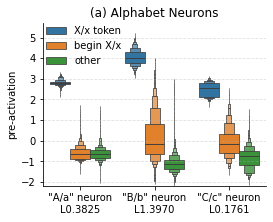

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.boxenplot(data=plot_df, x='neuron', y='value', hue='class', hue_order=class_labels, showfliers=False, ax=ax)

# change xticklabels
ax.set_xticklabels([
    f'"{l}/{l.lower()}" neuron\nL{n[0]}.{n[1]}' for l, n in zip(['A', 'B', 'C'], neurons)
])
ax.set_xlabel('')
ax.set_ylabel('pre-activation')
ax.set_title('(a) Alphabet Neurons')

ax.grid(axis='y', alpha=0.4, linestyle='--')

# change legend location to top left raised above plot
ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(-0.025, 1.04))
ax.set_ylim(-2.2, 5.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('figures/main_a_alphabet.png', bbox_inches='tight', dpi=150)